In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])        
    elif metric_name == 'distance':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']>=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']<metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']<metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']>=metric_value)))        
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])    
    return id_data, ood_data

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [4]:
def post_processing_old(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, metric_name, metric_value)
    
    return data,id_data,ood_data

In [5]:
def post_processing(data, model, metric_name, metric_value, proportion):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}_nonfixed_{proportion}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, metric_name, metric_value)
    
    return data,id_data,ood_data

In [6]:
data = load_dataset("beanham/spatial_join_dataset")
old_test=data['test']
newdata = concatenate_datasets([data['train'], data['val'], data['test']])

In [7]:
metric_name='degree'
metric_value=5
models=['heuristic','llama3']
proportions=[0.1,0.3,0.5,0.7]
metric_values=[5]
results=[]
for model in models:
    for proportion in proportions:
        subdata=newdata.train_test_split(train_size=proportion, seed=100)
        test = subdata['test']
        if proportion==0.7:
            pro_data,id_data,ood_data=post_processing_old(old_test,model,metric_name,metric_value)
        else:
            pro_data,id_data,ood_data=post_processing(test,model,metric_name,metric_value,proportion)
        acc,fpr,fnr=metric_calculation(pro_data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        results.append([model, metric_name, int(10227*proportion), acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
results=pd.DataFrame(results, columns=['model','metric','samples','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
results['total_count']=[len(test)]*len(results)
results['id_correct_count']=results.id_count.values*results.id_acc.values
results['ood_correct_count']=results.ood_count.values*results.ood_acc.values

### Angle Degrees

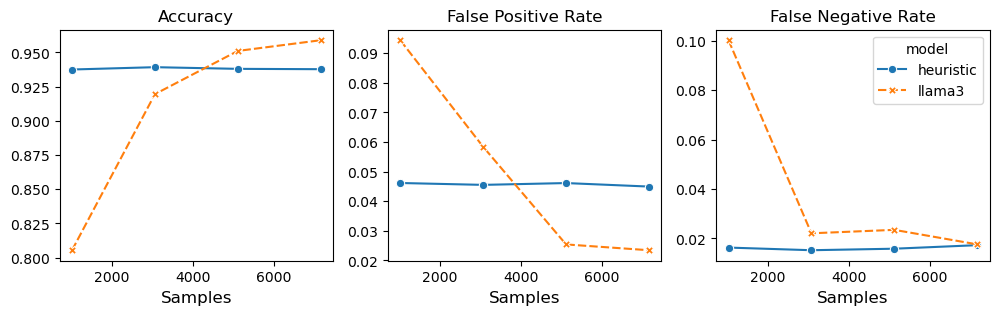

In [8]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=results, x="samples", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="samples", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=results, x="samples", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Samples', fontsize=12)
axs[1].set_xlabel('Samples', fontsize=12)
axs[2].set_xlabel('Samples', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
pass

## In-Distribution (ID) & Out-of-Distribution (OOD) Analysis

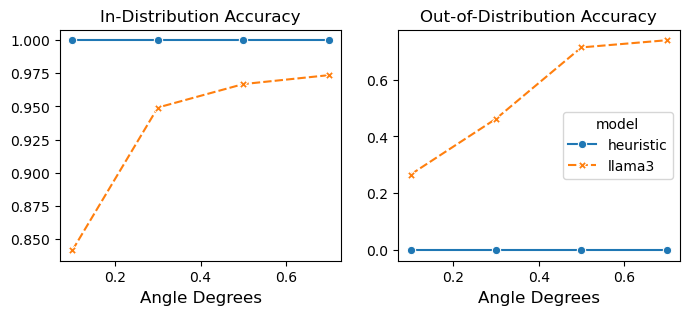

In [50]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Angle Degrees', fontsize=12)
axs[1].set_xlabel('Angle Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass